<a href="https://colab.research.google.com/github/jayeshgar/MyProjects/blob/main/HuggingFaceQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install Transformers and other libraries



In [14]:
!pip install farm-haystack==0.9.0
!pip install torch==1.8.1+cu111
!pip install torchvision==0.9.1+cu111
!pip install torchaudio==0.8.1
!pip install pymilvus==1.1.2
!pip install grpcio-tools==1.34.1

ERROR: Could not find a version that satisfies the requirement torch==1.8.1+cu111 (from versions: 1.0.0, 1.0.1, 1.0.1.post2, 1.1.0, 1.2.0, 1.3.0, 1.3.1, 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0)
ERROR: No matching distribution found for torch==1.8.1+cu111
ERROR: Could not find a version that satisfies the requirement torchvision==0.9.1+cu111 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.1.9, 0.2.0, 0.2.1, 0.2.2, 0.2.2.post2, 0.2.2.post3, 0.3.0, 0.4.0, 0.4.1, 0.4.2, 0.5.0, 0.6.0, 0.6.1, 0.7.0, 0.8.0, 0.8.1, 0.8.2, 0.9.0, 0.9.1, 0.10.0, 0.10.1, 0.11.0, 0.11.1, 0.11.2, 0.11.3, 0.12.0)
ERROR: No matching distribution found for torchvision==0.9.1+cu111


In [2]:
!pip install transformers[sentencepiece]
!pip install datasets==1.11.0

     |████████████████████████████████| 1.1 MB 3.8 MB/s 
  Attempting uninstall: sentencepiece
    Found existing installation: sentencepiece 0.1.96
    Uninstalling sentencepiece-0.1.96:
      Successfully uninstalled sentencepiece-0.1.96
     |████████████████████████████████| 264 kB 4.3 MB/s 
     |████████████████████████████████| 212 kB 43.0 MB/s 
     |████████████████████████████████| 136 kB 37.5 MB/s 


In [3]:
import pandas as pd

## Load and Pre-Process the dataset

In [4]:
from datasets import load_dataset
subjqa = load_dataset("subjqa", "electronics")

Downloading:   0%|          | 0.00/2.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.46k [00:00<?, ?B/s]

Downloading: 0.00B [00:00, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset subjqa downloaded and prepared to /root/.cache/huggingface/datasets/subjqa/electronics/1.1.0/e5588f9298ff2d70686a00cc377e4bdccf4e32287459e3c6baf2dc5ab57fe7fd. Subsequent calls will reuse this data.


In [5]:
subjqa.set_format("pandas")
# Flatten the nested dataset columns for easy access
dfs = {split:ds[:] for split, ds in subjqa.flatten().items()}
for split, df in dfs.items():
  print(f"Number of questions in {split}: {df['id'].nunique()}")

Number of questions in train: 1295
Number of questions in test: 358
Number of questions in validation: 255


In [6]:
qa_cols = ["title", "question", "answers.text",
"answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


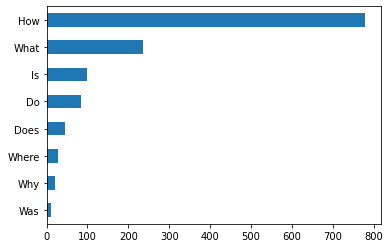

In [7]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]
for q in question_types:
  counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]
pd.Series(counts).sort_values().plot.barh();

In [8]:
for question_type in ["How", "What", "Is"]:
  for question in (dfs["train"][dfs["train"].question.str.startswith(question_type)].sample(n=3, random_state=42)['question']):
      print(question)
      print()

How is the camera?

How do you like the control?

How fast is the charger?

What is direction?

What is the quality of the construction of the bag?

What is your impression of the product?

Is this how zoom works?

Is sound clear?

Is it a wireless keyboard?



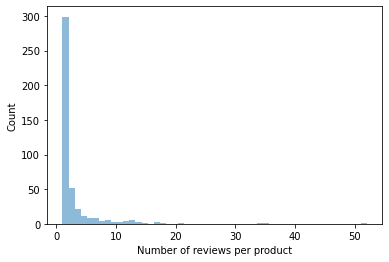

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
(dfs["train"].groupby("title")["review_id"].nunique()
.hist(bins=50, alpha=0.5, grid=False, ax=ax))
plt.xlabel("Number of reviews per product")
plt.ylabel("Count");

## Download and Run local Elastic Search

In [10]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [11]:
import os
from subprocess import Popen, PIPE, STDOUT
# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

In [12]:
!curl -X GET "localhost:9200/?pretty"
{
"name" : "n1hikaoslz",
"cluster_name" : "elasticsearch",
"cluster_uuid" : "2QZjiLIMSJKiGFLyatR_NQ",
"version" : {
"number" : "7.9.2",
"build_flavor" : "default",
"build_type" : "tar",
"build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
"build_date" : "2020-09-23T00:45:33.626720Z",
"build_snapshot" : "false",
"lucene_version" : "8.6.2",
"minimum_wire_compatibility_version" : "6.8.0",
"minimum_index_compatibility_version" : "6.0.0-beta1"
},
"tagline" : "You Know, for Search"
}

{
  "name" : "31f5af2f1677",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "CvNzzojgQ0-zdnvbmV4GJA",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


{'cluster_name': 'elasticsearch',
 'cluster_uuid': '2QZjiLIMSJKiGFLyatR_NQ',
 'name': 'n1hikaoslz',
 'tagline': 'You Know, for Search',
 'version': {'build_date': '2020-09-23T00:45:33.626720Z',
  'build_flavor': 'default',
  'build_hash': 'd34da0ea4a966c4e49417f2da2f244e3e97b4e6e',
  'build_snapshot': 'false',
  'build_type': 'tar',
  'lucene_version': '8.6.2',
  'minimum_index_compatibility_version': '6.0.0-beta1',
  'minimum_wire_compatibility_version': '6.8.0',
  'number': '7.9.2'}}

## End to End Pipeline using Transformers and Haystack

In [15]:
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore

In [16]:
# Return the document embedding for later use with dense Retriever
document_store = ElasticsearchDocumentStore(return_embedding=True)

05/06/2022 11:20:00 - INFO - elasticsearch -   HEAD http://localhost:9200/ [status:200 request:0.010s]
05/06/2022 11:20:01 - INFO - elasticsearch -   PUT http://localhost:9200/document [status:200 request:0.706s]
05/06/2022 11:20:02 - INFO - elasticsearch -   PUT http://localhost:9200/label [status:200 request:0.316s]


In [17]:
for split, df in dfs.items():
  # Exclude duplicate reviews
  docs = [{"text": row["context"],
  "meta":{"item_id": row["title"], "question_id": row["id"],
  "split": split}}
  for _,row in df.drop_duplicates(subset="context").iterrows()]
  document_store.write_documents(docs, index="document")
print(f"Loaded {document_store.get_document_count()} documents")

05/06/2022 11:20:15 - INFO - elasticsearch -   HEAD http://localhost:9200/document [status:200 request:0.007s]
05/06/2022 11:20:16 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.318s]
05/06/2022 11:20:17 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.171s]
05/06/2022 11:20:18 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.046s]
05/06/2022 11:20:18 - INFO - elasticsearch -   HEAD http://localhost:9200/document [status:200 request:0.004s]
05/06/2022 11:20:19 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:0.969s]
05/06/2022 11:20:19 - INFO - elasticsearch -   HEAD http://localhost:9200/document [status:200 request:0.003s]
05/06/2022 11:20:21 - INFO - elasticsearch -   POST http://localhost:9200/_bulk?refresh=wait_for [status:200 request:1.058s]
05/06/2022 11:20:21 - INFO - elasticsearch

Loaded 1615 documents


In [18]:
from haystack.retriever.sparse import ElasticsearchRetriever
es_retriever = ElasticsearchRetriever(document_store=document_store)

In [23]:
item_id = "B0074BW614"#Amazon Kindle Fire HD 7"
query = "Is it good for reading?"
#retrieved_docs = es_retriever.retrieve(query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [24]:
from haystack.reader.farm import FARMReader
model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
max_seq_len=max_seq_length, doc_stride=doc_stride,
return_no_answer=True)

05/06/2022 11:24:56 - INFO - farm.utils -   Using device: CUDA 
05/06/2022 11:24:56 - INFO - farm.utils -   Number of GPUs: 1
05/06/2022 11:24:56 - INFO - farm.utils -   Distributed Training: False
05/06/2022 11:24:56 - INFO - farm.utils -   Automatic Mixed Precision: None
Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertModel: ['qa_outputs.bias', 'qa_outputs.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
05/06/2022 11:25:07 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be lo

In [25]:
from haystack.pipeline import ExtractiveQAPipeline
pipe = ExtractiveQAPipeline(reader, es_retriever)

In [26]:
n_answers = 3
preds = pipe.run(query=query, top_k_retriever= 3, top_k_reader= n_answers,filters= {"item_id": [item_id], "split":["train"]})
print(f"Question: {preds['query']}", "\n")
#print(preds['answers'][0].answer)
for idx in range(n_answers):
  print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")
  print(f"Review snippet: ...{preds['answers'][idx]['context']}...")
  print("\n\n")

05/06/2022 11:25:16 - INFO - elasticsearch -   POST http://localhost:9200/document/_search [status:200 request:0.018s]


Question: Is it good for reading? 

Answer 1: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I mainly use it for book reading.  I decided to try the fire for when I travel I take my la...



Answer 2: the larger screen compared to the Kindle makes for easier reading
Review snippet: ...ght enough that I can hold it to read, but the larger screen compared to the Kindle makes for easier reading. I love the color, something I never thou...



Answer 3: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great for reading books when no light is available. Amazing sound but I suggest good headphones t...



